# Code Generation

## Langgraph Architecture

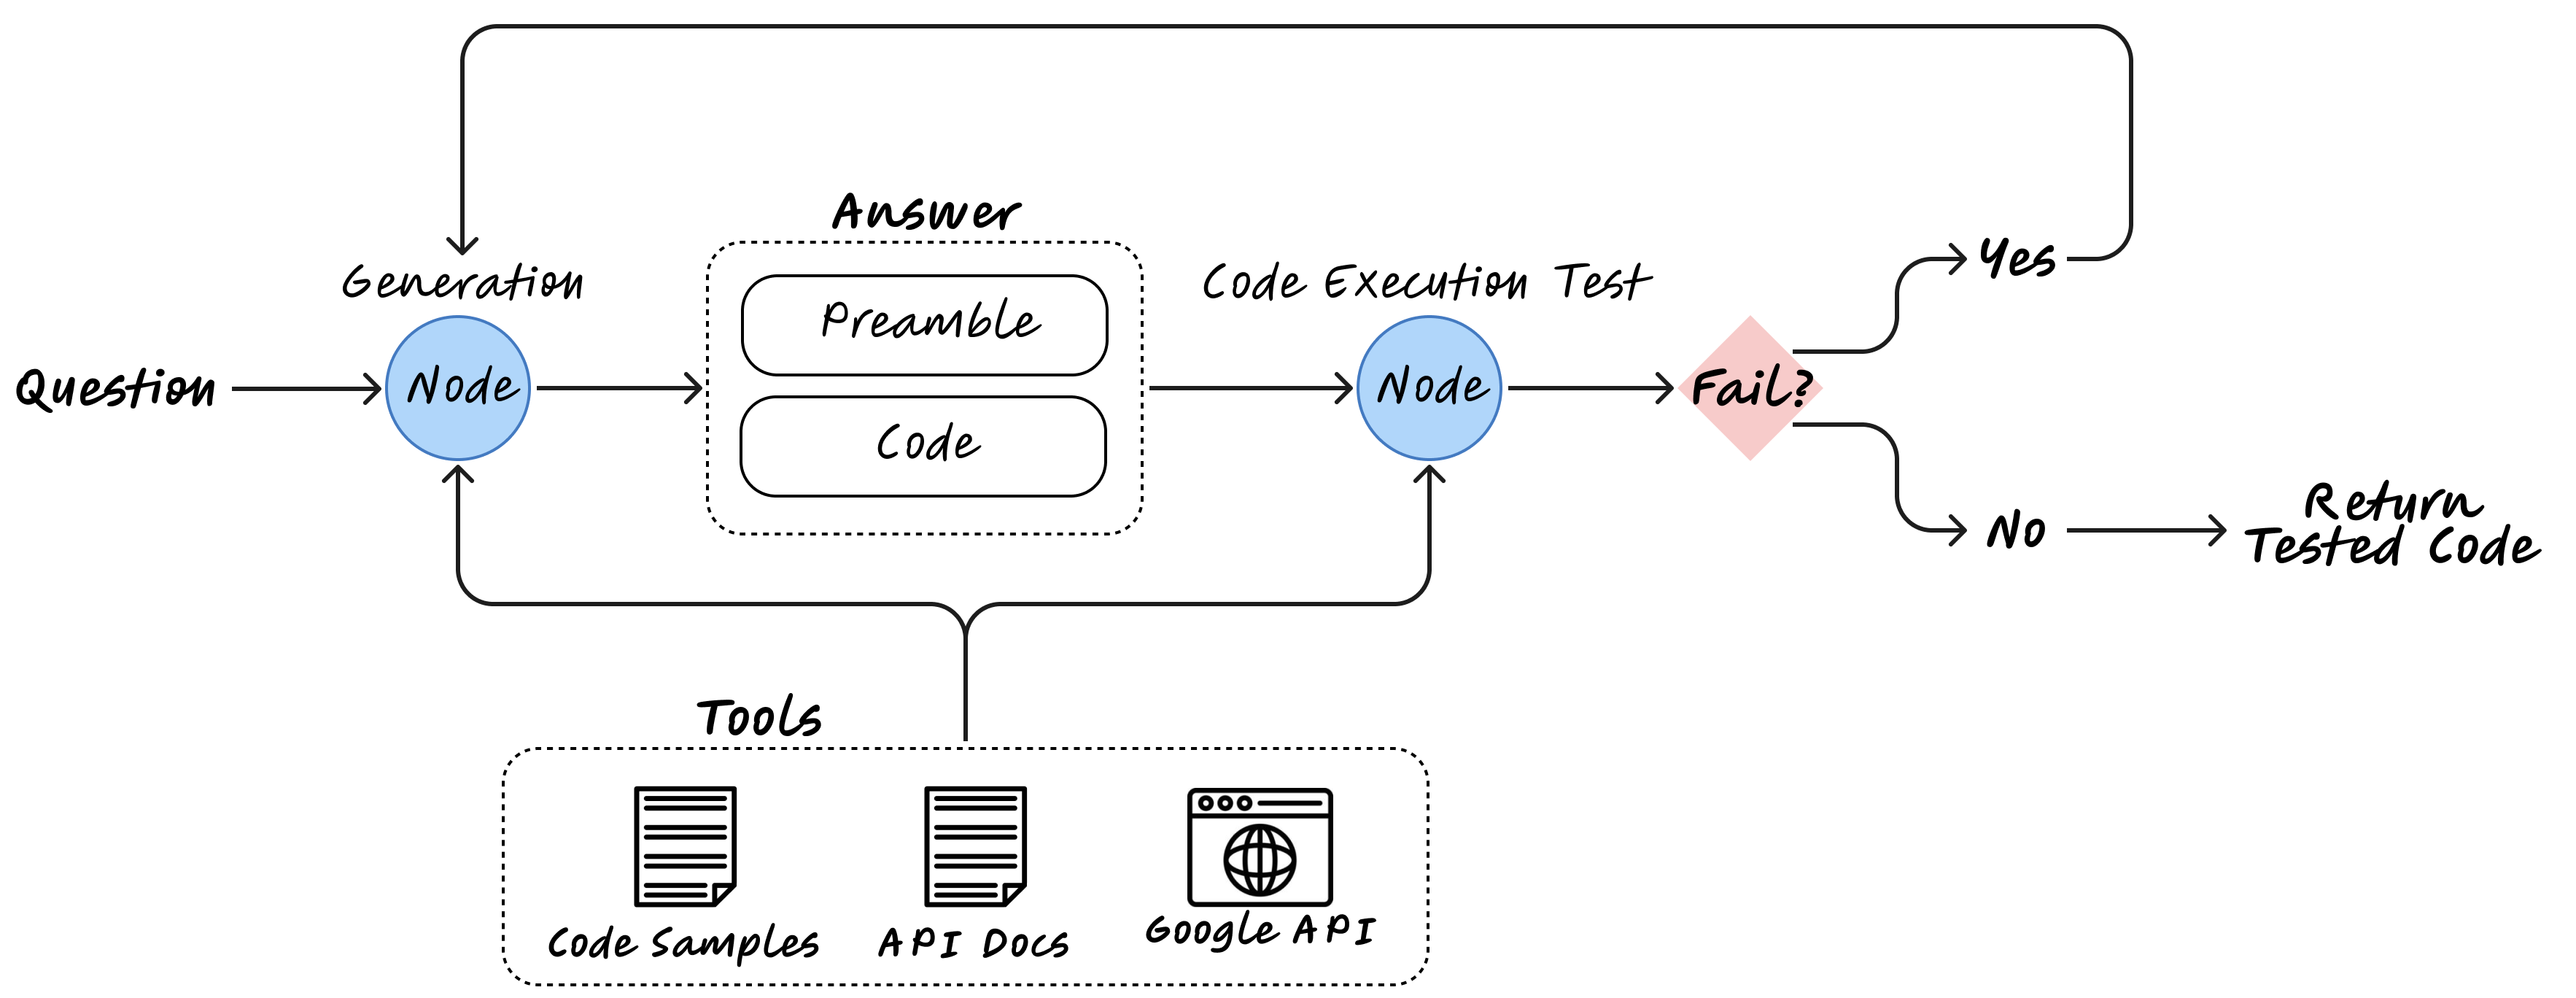

In [1]:
%load_ext dotenv

# Langgraph

In [2]:
# common
import os
from typing import Dict, TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

COLOR = {
    "HEADER": "\033[95m",
    "BLUE": "\033[94m",
    "GREEN": "\033[92m",
    "RED": "\033[91m",
    "ENDC": "\033[0m",
}

In [3]:
# nodes

import sys, os
from operator import itemgetter
import subprocess
import tempfile

from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_anthropic.experimental import ChatAnthropicTools
from langchain import hub

ANTHROPIC_API_KEY=os.getenv("ANTHROPIC_API_KEY")

class Nodes:
    def __init__(self, context: str, debug: bool = False):
        self.context = context
        self.debug = debug
        self.model = (
            "claude-3-opus-20240229"
        )
        self.node_map = {
            "generate": self.generate,
            "check_code_execution": self.check_code_execution,
            "finish": self.finish,
        }

    def generate(self, state: GraphState) -> GraphState:
        """
        Generate a code solution based on docs and the input question
        with optional feedback from code execution tests

        Args:
            state (dict): The current graph state

        Returns:
            state (dict): New key added to state, documents, that contains retrieved documents
        """

        ## State
        state_dict = state["keys"]
        question = state_dict["question"]
        iter = state_dict["iterations"]

        ## Data model
        class code(BaseModel):
            """Code output"""

            prefix: str = Field(
                description="Description of the problem and approach"
            )
            code: str = Field(
                description="Code block not including import statements"
            )
            
        llm_with_tool = ChatAnthropicTools(
            model=self.model
            ).bind_tools(
            tools=[code],
            tool_choice="code",
        ).with_config(
            run_name="code"
        ) 

        # Parser
        parser_tool = PydanticToolsParser(tools=[code])

        ## Prompt
        prompt = hub.pull("neuronslab/aws_cdk_engineer")

        # Chain
        chain = (
            {
                "context": lambda _: self.context,
                "question": itemgetter("question"),
                "generation": itemgetter("generation"),
                "error": itemgetter("error"),
            }
            | prompt
            | llm_with_tool
            | parser_tool
        )

        ## Generation
        if "error" in state_dict:
            print("---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---")

            error = state_dict["error"]
            code_solution = state_dict["generation"]

            code_solution = chain.invoke(
                {
                    "question": question,
                    "generation": str(code_solution[0]),
                    "error": error,
                }
            )

        else:
            print("---GENERATE SOLUTION---")

            code_solution = chain.invoke(
                {
                    "question": question,
                    "generation": "",
                    "error": ""
                }
            )

        iter = iter + 1
        return {
            "keys": {
                "generation": code_solution,
                "question": question,
                "iterations": iter,
            }
        }

    def check_code_execution(self, state: GraphState) -> GraphState:
        """
        Check code block execution

        Args:
            state (dict): The current graph state

        Returns:
            state (dict): New key added to state, error
        """

        ## State
        print("---CHECKING CODE EXECUTION---")
        state_dict = state["keys"]
        question = state_dict["question"]
        code_solution = state_dict["generation"]
        prefix = code_solution[0].prefix
        code_block = code_solution[0].code
        iter = state_dict["iterations"]

        print(
            f"{COLOR['GREEN']}{code_block}{COLOR['ENDC']}",
            sep="\n",
        )


        
        tmp = tempfile.NamedTemporaryFile()
        tmp.write(code_block.encode())
        tmp.flush()
        result = subprocess.run(
            f'cdk synth --validation --app "python3 {tmp.name}"',
            shell=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            )
        tmp.close()


        output, error = result.stdout, result.stderr
        if result.returncode:
            print("---CODE BLOCK CHECK: FAILED---")
            error = f"Execution error: {error}"
            print(f"Error: {error}", file=sys.stderr)
            if "error" in state_dict:
                error_prev_runs = state_dict["error"]
                error = (
                    error_prev_runs
                    + "\n --- Most recent run output and error --- \n"
                    " ------ output ------ \n"
                    + output
                    + "\n ------ error ------ \n"
                    + error
                )
        else:
            print("---CODE BLOCK CHECK: SUCCESS---")
            # No errors occurred
            error = "None"

        return {
            "keys": {
                "generation": code_solution,
                "question": question,
                "error": error,
                "prefix": prefix,
                "iterations": iter,
                "code": code_block,
            }
        }

    def finish(self, state: GraphState) -> dict:
        """
        Finish the graph

        Returns:
            dict: Final result
        """

        print("---FINISHING---")

        response = extract_response(state)

        return {"keys": {"response": response}}


def extract_response(state: GraphState) -> str:
    """
    Extract the response from the graph state

    Args:
        state (dict): The current graph state

    Returns:
        str: The response
    """

    state_dict = state["keys"]
    code_solution = state_dict["generation"][0]
    prefix = code_solution.prefix
    code = code_solution.code

    return {
        "prefix": prefix,
        "code": code,
    }


In [4]:
# Edges

"""Defines functions that transition our agent from one state to another."""


def enrich(graph):
    """Adds transition edges to the graph."""

    graph.add_edge("generate", "check_code_execution")
    graph.add_conditional_edges(
        "check_code_execution",
        decide_to_finish,
        {
            "finish": "finish",
            "generate": "generate",
        },
    )

    return graph


def decide_to_check_code_exec(state: GraphState) -> str:
    """
    Determines whether to test code execution, or re-try answer generation.

    Args:
    state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]

    if error == "None":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "check_code_execution"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


def decide_to_finish(state: GraphState) -> str:
    """
    Determines whether to finish (re-try code 3 times).

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    error = state_dict["error"]
    iter = state_dict["iterations"]

    if error == "None" or iter >= 3:
        print("---DECISION: FINISH---")
        return "finish"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"


In [5]:
# Agent

def construct_graph(debug=False):
    from langgraph.graph import StateGraph

    context = "" # retrieval.retrieve_docs(debug=debug)

    graph = StateGraph(GraphState)

    # attach our nodes to the graph
    graph_nodes = Nodes(context, debug=debug)
    for key, value in graph_nodes.node_map.items():
        graph.add_node(key, value)

    # construct the graph by adding edges
    graph = enrich(graph)

    # set the starting and ending nodes of the graph
    graph.set_entry_point(key="generate")
    graph.set_finish_point(key="finish")

    return graph

In [6]:
# App
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware

web_app = FastAPI(
    title="CodeLangChain Server",
    version="1.0",
    description="Answers questions about LangChain Expression Language (LCEL).",
)


# Set all CORS enabled origins
web_app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
    expose_headers=["*"],
)


def serve():
    from langchain_core.runnables import RunnableLambda
    from langserve import add_routes

    def inp(question: str) -> dict:
        return {"keys": {"question": question, "iterations": 0}}

    def out(state: dict) -> str:
        if "keys" in state:
            return state["keys"]["response"]
        elif "generate" in state:
            return extract_response(state["generate"])
        else:
            return str(state)

    graph = construct_graph(debug=False).compile()

    chain = RunnableLambda(inp) | graph | RunnableLambda(out)

    add_routes(
        web_app,
        chain,
        path="/codelangchain",
    )

    return web_app


In [7]:
def go(question: str = "Create VPC with 2 Public subnets", debug: bool = False):
    """Compiles the code generation agent graph and runs it, returning the result."""
    graph = construct_graph(debug=debug)
    runnable = graph.compile()
    result = runnable.invoke(
        {"keys": {"question": question, "iterations": 0}},
        config={"recursion_limit": 50},
    )

    return result

In [8]:
question = """Create a EC2 instance with latest version of Amazon Linux.
Install the latest version of nginx, enable it and start the service.
Instance is in public subnet.
Find existing VPC vpc-0fed7b21fa59b0985, in us-east-1 in 433559402488 aws account for the instance.
Open port 80 and 443 in the security group to 0.0.0.0/0.
Secure the instance with EBS encryption.
"""
result = go(question=question)

/Users/artemkobrin/repositories/nl/codegen-aws-cdk-demo/.venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:86: LangChainBetaWarning: The class `ChatAnthropicTools` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


---GENERATE SOLUTION---
---CHECKING CODE EXECUTION---
from aws_cdk import (
    Stack,
    aws_ec2 as ec2,
    App
)
from constructs import Construct

class Ec2Stack(Stack):
    def __init__(self, scope: Construct, id: str, **kwargs) -> None:
        super().__init__(scope, id, **kwargs)

        # Look up the existing VPC 
        vpc = ec2.Vpc.from_lookup(self, "VPC",
            vpc_id="vpc-0fed7b21fa59b0985"
        )
        
        # Create the security group and allow inbound HTTP/HTTPS
        sec_group = ec2.SecurityGroup(self, "SecurityGroup",
            vpc=vpc,
            allow_all_outbound=True
        )
        sec_group.add_ingress_rule(ec2.Peer.any_ipv4(), ec2.Port.tcp(80))
        sec_group.add_ingress_rule(ec2.Peer.any_ipv4(), ec2.Port.tcp(443))
      
        # Get the latest Amazon Linux AMI
        amzn_linux = ec2.MachineImage.latest_amazon_linux(
            generation=ec2.AmazonLinuxGeneration.AMAZON_LINUX_2,
            edition=ec2.AmazonLinuxEdition.STANDAR

Error: Execution error: b'jsii.errors.JavaScriptError: \n  @jsii/kernel.RuntimeError: Error: Cannot retrieve value from context provider vpc-provider since account/region are not specified at the stack level. Configure "env" with an account and region when you define your stack.See https://docs.aws.amazon.com/cdk/latest/guide/environments.html for more details.\n      at Kernel._Kernel_ensureSync (/private/var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmptwh9zq85/lib/program.js:10491:23)\n      at Kernel.sinvoke (/private/var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmptwh9zq85/lib/program.js:9876:102)\n      at KernelHost.processRequest (/private/var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmptwh9zq85/lib/program.js:11696:36)\n      at KernelHost.run (/private/var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmptwh9zq85/lib/program.js:11656:22)\n      at Immediate._onImmediate (/private/var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmptwh9zq85/lib/program.js:11657:46)\n     

---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---
---CHECKING CODE EXECUTION---
from aws_cdk import (
    Stack,
    aws_ec2 as ec2,
    App
)
from constructs import Construct

class Ec2Stack(Stack):
    def __init__(self, scope: Construct, id: str, **kwargs) -> None:
        super().__init__(scope, id, **kwargs)

        # Look up the existing VPC 
        vpc = ec2.Vpc.from_lookup(self, "VPC",
            vpc_id="vpc-0fed7b21fa59b0985"
        )
        
        # Create the security group and allow inbound HTTP/HTTPS
        sec_group = ec2.SecurityGroup(self, "SecurityGroup",
            vpc=vpc,
            allow_all_outbound=True
        )
        sec_group.add_ingress_rule(ec2.Peer.any_ipv4(), ec2.Port.tcp(80))  
        sec_group.add_ingress_rule(ec2.Peer.any_ipv4(), ec2.Port.tcp(443))
      
        # Get the latest Amazon Linux AMI
        amzn_linux = ec2.MachineImage.latest_amazon_linux( 
            generation=ec2.AmazonLinuxGeneration.AMAZON_LINUX_2,
            edition=ec2.Am

In [10]:
# parse http response and extract json

import json

def parse_sse_and_extract_json(sse_content):
    events = sse_content.strip().split("\n\n")
    for event in events:
        lines = [line for line in event.split("\n") if line]  # Remove empty lines
        for i, line in enumerate(lines):
            if line.startswith("event: data"):
                # Assuming the very next line after "event: data" contains the JSON data
                if i + 1 < len(lines) and lines[i+1].startswith("data:"):
                    try:
                        json_data = json.loads(lines[i+1][len("data:"):].strip())
                        return json_data
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON: {e}")
                        return None
    return None

In [11]:
import requests

response = requests.post(
    "http://localhost:8000/codelangchain/stream",
    json={
        "input": "Create VPC with 2 Public subnets",
        "config": {},
        "kwargs": {}
    }
)
code = parse_sse_and_extract_json(response.text)["code"]
print(code)

from aws_cdk import (
    Stack,
    aws_ec2 as ec2,
    App
)
from constructs import Construct

class VpcStack(Stack):

    def __init__(self, scope: Construct, construct_id: str, **kwargs) -> None:
        super().__init__(scope, construct_id, **kwargs)

        vpc = ec2.Vpc(
            self, "MyVpc", 
            max_azs=2, # Use 2 AZs
            cidr="10.0.0.0/16", 
            
            # Configure 2 public subnets 
            subnet_configuration=[
                ec2.SubnetConfiguration(
                    name="PublicSubnet1",
                    subnet_type=ec2.SubnetType.PUBLIC,
                    cidr_mask=24
                ),
                ec2.SubnetConfiguration(
                    name="PublicSubnet2",  
                    subnet_type=ec2.SubnetType.PUBLIC,
                    cidr_mask=24
                )
            ]
        )

# Create the CDK app and VPC stack        
app = App()
VpcStack(app, "VpcStack")

# Generate the CloudFormation template
app.syn

In [31]:
import tempfile
tmp = tempfile.NamedTemporaryFile()
tmp.write(code.encode())
tmp.flush()

In [19]:
tmp.name

'/var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmpl6ycro4b'

In [23]:
!cdk synth --validation --app "python3 /var/folders/z8/mdmwx43d3dncqq27d29dhhjw0000gn/T/tmpl6ycro4b"


[WARNING] aws-cdk-lib.aws_ec2.VpcProps#cidr is deprecated.
  Use ipAddresses instead
  This API will be removed in the next major release.
Resources:
  MyVpcF9F0CA6F:
    Type: AWS::EC2::VPC
    Properties:
      CidrBlock: 10.0.0.0/16
      EnableDnsHostnames: true
      EnableDnsSupport: true
      InstanceTenancy: default
      Tags:
        - Key: Name
          Value: VpcStack/MyVpc
    Metadata:
      aws:cdk:path: VpcStack/MyVpc/Resource
  MyVpcPublicSubnet1Subnet1SubnetAB9C6797:
    Type: AWS::EC2::Subnet
    Properties:
      AvailabilityZone:
        Fn::Select:
          - 0
          - Fn::GetAZs: ""
      CidrBlock: 10.0.0.0/24
      MapPublicIpOnLaunch: true
      Tags:
        - Key: aws-cdk:subnet-name
          Value: PublicSubnet1
        - Key: aws-cdk:subnet-type
          Value: Public
        - Key: Name
          Value: VpcStack/MyVpc/PublicSubnet1Subnet1
      VpcId:
        Ref: MyVpcF9F0CA6F
    Metadata:
      aws:cdk:path: VpcStack/MyVpc/PublicSubnet1Subnet1